# Summary
In this notebook we construct a combined model, that is expecting a 12-leads ECG readings, first impute their empty values (using the upstream model's weights) and then takes the imputed ECG signal and use it to predict the target(s).  
We do not train anything yet.

# Setup

In [5]:
import os
os.getcwd()

'/Users/davidharar/Documents/School/thesis/combined_downstream_upstram/notebooks'

In [6]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from typing import List
import pandas as pd

import os
os.chdir('/Users/davidharar/Documents/School/thesis/')
downstream_path = './downstream_classification/'
upstream_path = './upstream_seq2seq/'

from downstream_classification.dataloader.DataLoader import DataGenerator

train_generator = DataGenerator(
    metadata_file_path= f'{downstream_path}/data/combined_data/metadata.csv',   # path to metadata file
    data_folder_path = f'{downstream_path}/data/individual-signals/',     # path to individual signals
    sample='train',               # sample we want to create a generator to. Either train, validation or test
    targets=['one_year_until_death'],             # list of targets we want train on
    batch_size=4,           # batch size
    shuffle=True,       # Whether to shuffle the list of IDs at the end of each epoch.
    fillna=0         
    )

X,y = train_generator.__getitem__(1224)
print(X.shape, y.shape)
X,y

(4, 12, 450) (4, 1, 1)


(array([[[0.35402725, 0.35850949, 0.3635456 , ..., 0.39769277,
          0.40853832, 0.43354973],
         [0.22749712, 0.24434748, 0.25342457, ..., 0.15771653,
          0.15373151, 0.15559684],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.28215296, 0.30072478, 0.3116115 , ..., 0.51373526,
          0.36663725, 0.16333737],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.27478585, 0.26573882, 0.26672554, ..., 0.18485005,
          0.19117195, 0.19700235],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.

# Modeling

## Upstream

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import torch

from tqdm import tqdm

import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer

from upstream_seq2seq.modeling.Transformer import TSTransformerEncoder
import torch

device = 'mps'

## Downstream

In [8]:
from downstream_classification.modeling.Inception import *
lr,dropout,class_weight,weight_decay = (0.001, 0.2, 50.0, 0.0005)
loss_function_weight = torch.tensor([class_weight]).to(device)

downstream_model = DownstreamInception(dropout, num_inputs=12).to(device)
optimizer = optim.AdamW(downstream_model.parameters(), weight_decay=weight_decay, lr=lr)
criterion = nn.BCELoss(loss_function_weight)


# Combine Model

In [10]:
[x for x in os.listdir('./downstream_classification/models/') if '50' in x]

['3.0-inception-bs128-imbalanced-death-aucpr-0.001-0.0005-0.2-50.0.pt',
 '3.0-inception-bs128-imbalanced-death-aucpr-0.001-0.0005-0.2-50.0_loss.pkl',
 '3.0-inception-bs128-imbalanced-death-aucpr-0.005-0-0.5-50.0_loss.pkl',
 '3.0-inception-bs128-imbalanced-death-aucpr-0.001-0-0.2-50.0.pt',
 '3.0-inception-bs128-imbalanced-death-aucpr-0.001-0-0.2-50.0_loss.pkl',
 '3.0-inception-bs128-imbalanced-death-aucpr-0.005-0-0.5-50.0.pt']

In [11]:
class CombinedModel(torch.nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()


        model_name = 'exp4-base-version-with-train-by-sample-window-450_1695652345.7981088.pt'
        downstream_model_path = './downstream_classification/models/3.0-inception-bs128-imbalanced-death-aucpr-0.001-0-0.2-50.0.pt'



        input_dimension          = 12
        output_dimension         = 12
        hidden_dimmension        = 64
        attention_heads          = None
        decoder_number_of_layers = 8
        positional_encodings     = False
        dropout                  = 0.4
        device                   = 'mps'
        upstream_model = TSTransformerEncoder(input_dimension, output_dimension, 
                            hidden_dimmension, attention_heads, 
                            decoder_number_of_layers, positional_encodings,dropout).\
                                to(device)
        upstream_model.load_state_dict(torch.load(f'{upstream_path}/models/{model_name}'))

        downstream_model = DownstreamInception(dropout, num_inputs=12).to(device)
        downstream_model.load_state_dict(torch.load(downstream_model_path))

        self.modelA = upstream_model
        self.modelB = downstream_model
        self.modelA.eval()
        self.modelB.eval()
        
        print(f'The upstream model has {count_parameters(self.modelA):,} trainable parameters')
        print(f'The downstream model has {count_parameters(self.modelB):,} trainable parameters')
        
        
    def forward(self, x):
        
        with torch.no_grad():
            Y = self.modelA(x,None) #.cpu().numpy()
            Y = Y.permute((1,2,0))
            Y = self.modelB(Y)
        # x = self.modelA(x,None)
        # x = self.modelB(x)
        return Y
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

combined_model = CombinedModel()
print(combined_model)

64 1
The upstream model has 666,509 trainable parameters
The downstream model has 651,257 trainable parameters
CombinedModel(
  (modelA): TSTransformerEncoder(
    (project_input): Linear(in_features=12, out_features=64, bias=True)
    (encoder): Linear(in_features=12, out_features=64, bias=True)
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=512, bias=True)
          (dropout): Dropout(p=0.4, inplace=False)
          (linear2): Linear(in_features=512, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=T

/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because  self.layers[0].self_attn.batch_first was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [12]:
def process(X):
    src_ = np.float32(np.transpose(X, axes=(2,0,1)))
    src_ = torch.from_numpy(src_).to(device)
    return src_

combined_model(process(X))



tensor([[0.0127],
        [0.0146],
        [0.0036],
        [0.0102]], device='mps:0')

# Extract Values

In [13]:
import pandas as pd
metadata = pd.read_csv(f'{downstream_path}/data/combined_data/metadata.csv')
metadata

,Unnamed: 0,sample,reading,dates,one_year_until_death,CVA,first_AF_in_home_ECG,first_AF_in_Dispatch,AF,IHD,sp_MI_all,sp_CABG,CHF,sp_CPR,cpr_shl,DM2,AF2,DM
0,0,train,427805,20/01/2008,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,train,356921,23/02/2010,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,2,train,428248,19/12/2015,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,train,440621,18/08/2017,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,train,32229,10/07/2019,0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395767,395767,test,387849,01/04/2001,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395768,395768,test,395752,23/04/2012,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395769,395769,test,434377,03/09/2012,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395770,395770,test,384590,10/09/2000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
train_generator = DataGenerator(
    metadata_file_path= f'{downstream_path}/data/combined_data/metadata.csv',   # path to metadata file
    data_folder_path = f'{downstream_path}/data/individual-signals/',     # path to individual signals
    sample='train',               # sample we want to create a generator to. Either train, validation or test
    targets=['one_year_until_death', 'reading'],             # list of targets we want train on
    batch_size=4,           # batch size
    shuffle=True,       # Whether to shuffle the list of IDs at the end of each epoch.
    fillna=0         
    )

X,y = train_generator.__getitem__(1224)
y = np.squeeze(y)
label, signal = y[:,0],y[:,1]
label = label.tolist()
signal = signal.tolist()


array([0, 0, 0, 0])

In [82]:
train_generator = DataGenerator(
    metadata_file_path= f'{downstream_path}/data/combined_data/metadata_only_existant_readings_09042023.csv',   # path to metadata file
    data_folder_path = f'{downstream_path}/data/individual-signals/',     # path to individual signals
    sample='validation',               # sample we want to create a generator to. Either train, validation or test
    targets=['one_year_until_death', 'reading'],             # list of targets we want train on
    batch_size=512,           # batch size
    shuffle=True,       # Whether to shuffle the list of IDs at the end of each epoch.
    fillna=0         
    )

X,y = train_generator.__getitem__(1224)
print(X.shape, y.shape)

def get_number_of_empty_leads(X):
    sums = np.sum(np.mean(X,axis=-1) == 0,axis=-1)
    return sums


indices = 0
labels = []
signals = []
empty_leads = []
scores = []
for j in tqdm(range(train_generator.__len__())):
    # load data
    X,y = train_generator.__getitem__(j)

    # calc empty leads
    empty_leads_batch = get_number_of_empty_leads(X)

    # get signals and labels
    y = np.squeeze(y)
    label, signal = y[:,0],y[:,1]
    label = label.tolist()
    signal = signal.tolist()

    # process X
    X = process(X)

    # get scores for batch
    score = combined_model(X)

    # store values
    signals += signal
    scores += score.cpu().numpy().tolist()
    empty_leads += empty_leads_batch.tolist()
    labels += label


(0,) (0,)


100%|██████████| 104/104 [03:49<00:00,  2.20s/it]


In [83]:
scores = [x[0] for x in scores]


In [68]:
len(signals), len(scores), len(empty_leads), len(labels)

(262144, 262144, 262144, 262144)

In [84]:
pd.DataFrame({'signal':signals, 
              'scores': scores, 
              'empty_leads':empty_leads,
              'label':labels}).\
                to_csv(f'{downstream_path}/summary_stats_and_tables/combined_model_on_SHL_without_tuning_validation.csv')

<Axes: xlabel='scores', ylabel='Probability'>

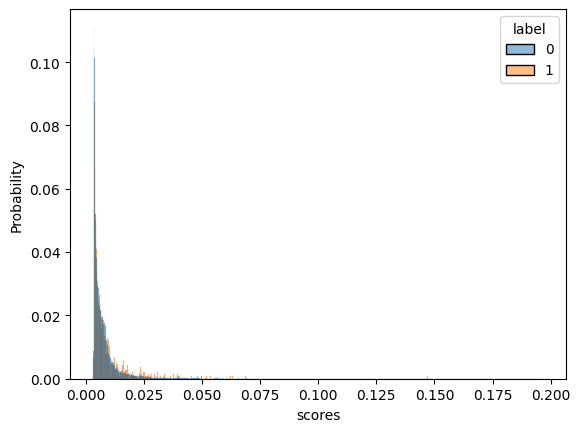

In [85]:
data = \
    pd.DataFrame({'signal':signals, 
              'scores': scores, 
              'empty_leads':empty_leads,
              'label':labels})

import seaborn as sns

sns.histplot(data = data,
             x = 'scores', hue = 'label',
             common_norm=False, stat='probability')

In [53]:
from sklearn.metrics import average_precision_score

In [86]:
average_precision_score(data['label'],
                        data['scores'])

0.030594919745973885

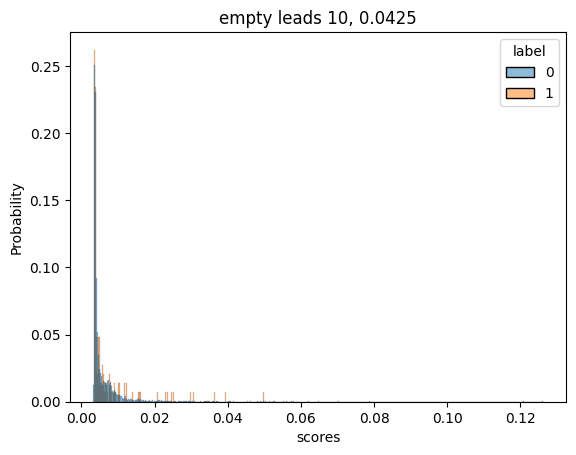

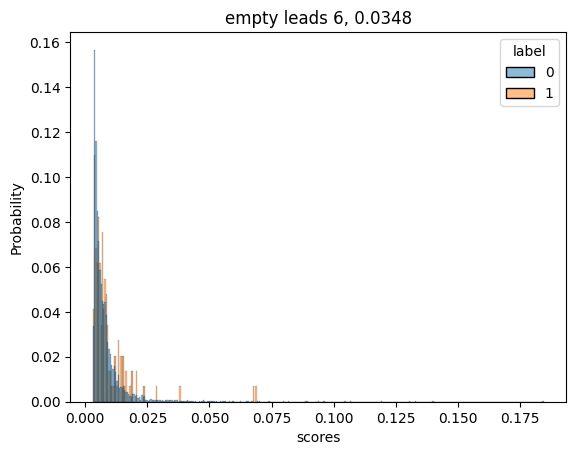

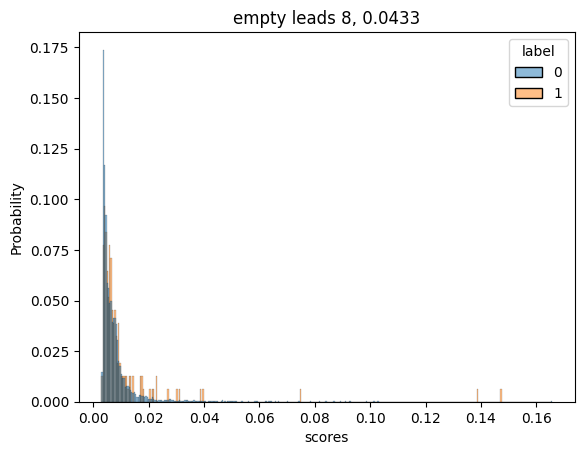

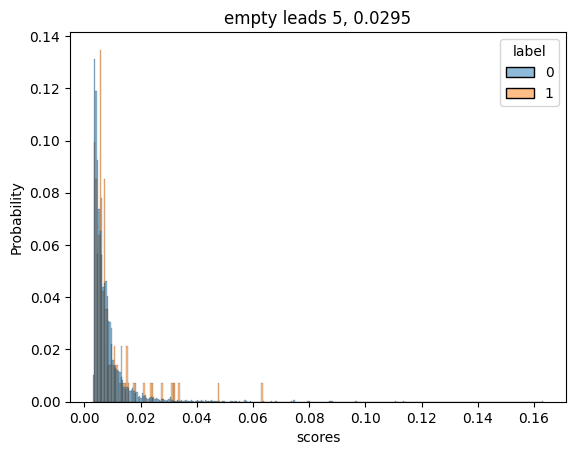

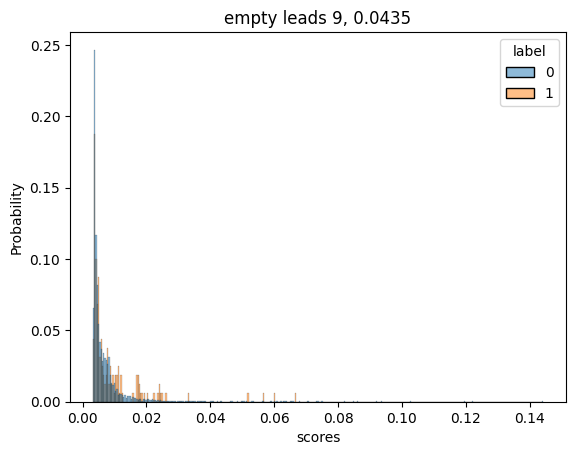

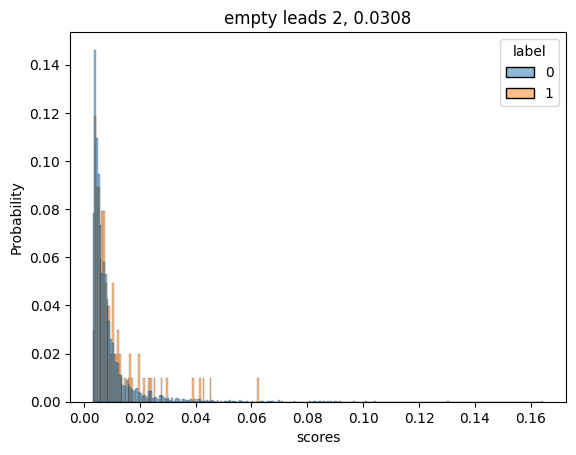

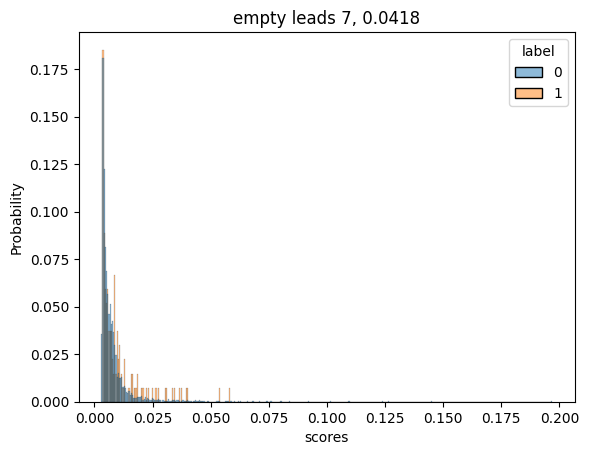

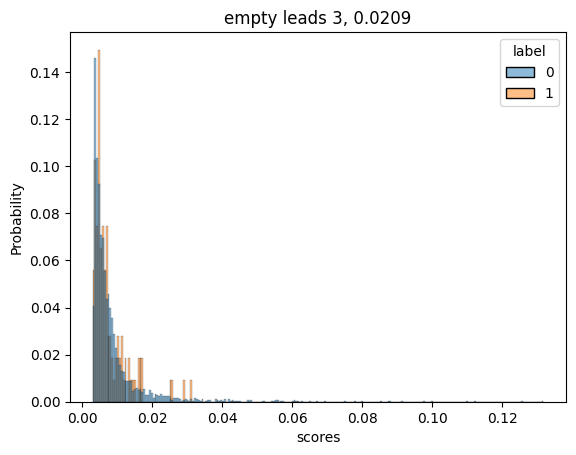

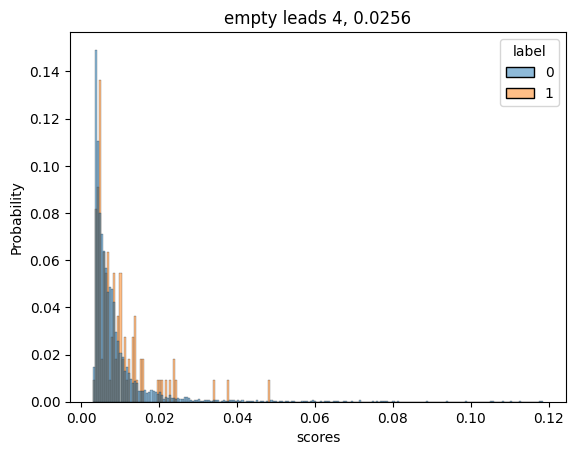

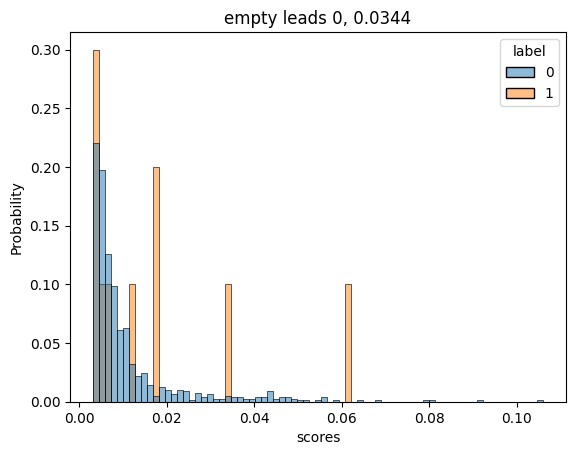

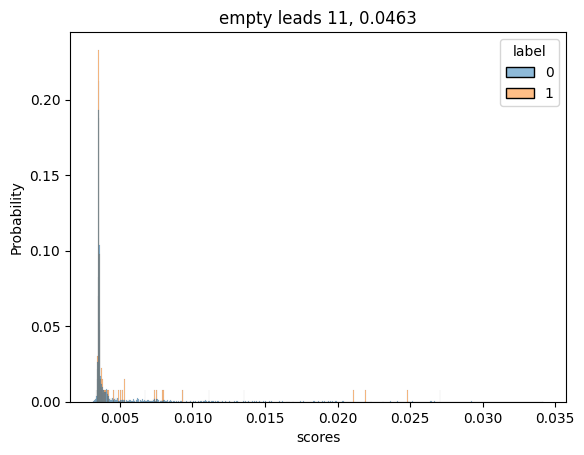

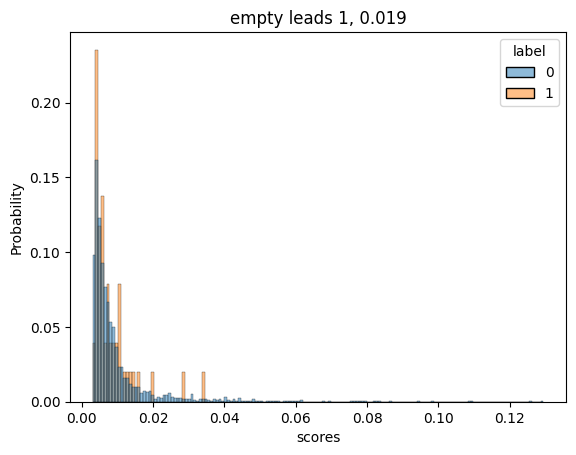

In [87]:
for empty_leads_number in data['empty_leads'].unique():
    mask = data['empty_leads'] == empty_leads_number
    num = np.round(average_precision_score(data[mask]['label'], 
                                                data[mask]['scores']),
                                                4)
    sns.histplot(data = data[mask],
                x = 'scores', hue = 'label',
                common_norm=False, stat='probability')
    plt.title(f'empty leads {empty_leads_number}, {num}')

    plt.show()